In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter
import numba
from numba import jit

In [ ]:
## TO RUN WHILE USING GOOGLE-COLAB
# !pip install numba --q
# !pip install qiskit ipywidgets --q 
# !wget https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qmcmc_codes/qbm_utils_2.py

In [ ]:
from qbm_utils_2 import *

### Define the model

In [ ]:
# define the model
np.random.seed(1)# should always be in the same cell!  
n_spins = 20

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

# defining J matrix (mutual 1-1 interaction)
J =  np.round(np.random.uniform(low= -1, high= 1, size = (n_spins,n_spins)), decimals=2)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
# print("J before:"); print(J)
J= J - np.diag(np.diag(J))

# J=np.array([[0,1,0.5,-1],[1,0,0.3,0.5],[0.5,0.3,0,1],[-1,0.5,1,0]])
print("J after:", J)

# defining h
h = np.round(np.random.randn(n_spins), decimals=2)#np.random.uniform(low= -1, high = 1, size= (n_spins))
# h=np.array([0.5]*n_spins)
print("h is:", h)

# instantiate the model
model = IsingEnergyFunction(J, h)
# print(model.get_energy('0100'))
alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )
print("alpha: ", alpha)

J after: [[ 0.     0.52  -0.01  -0.6    0.03  -0.585 -0.795 -0.1   -0.365  0.17
   0.37  -0.14  -0.48   0.63  -0.095  0.48  -0.17   0.425 -0.56  -0.36 ]
 [ 0.52   0.     0.065  0.105  0.5    0.42  -0.89  -0.825 -0.335  0.09
  -0.345 -0.25   0.855  0.395  0.595  0.19   0.3    0.785 -0.835  0.33 ]
 [-0.01   0.065  0.     0.485 -0.145  0.335 -0.06  -0.645 -0.09  -0.115
  -0.065 -0.19  -0.21   0.02   0.155 -0.255 -0.19  -0.03   0.49   0.69 ]
 [-0.6    0.105  0.485  0.    -0.6   -0.11  -0.09  -0.365  0.775 -0.35
   0.545 -0.055 -0.675  0.505 -0.33  -0.265  0.03   0.205  0.29  -0.07 ]
 [ 0.03   0.5   -0.145 -0.6    0.     0.805  0.29   0.01  -0.18  -0.12
  -0.495  0.295  0.24   0.445 -0.34  -0.605  0.42  -0.325 -0.02  -0.135]
 [-0.585  0.42   0.335 -0.11   0.805  0.    -0.445  0.035 -0.29   0.8
  -0.345  0.075  0.545  0.02  -0.08   0.22   0.23   0.575  0.345 -0.615]
 [-0.795 -0.89  -0.06  -0.09   0.29  -0.445  0.     0.065 -0.805 -0.525
   0.19   0.55  -0.385 -0.31   0.33  -0.42  -0.04   0.0

### Get the true distribution

In [ ]:
# @jit(nopython = True)
def true_boltzman_distn(n_spins:int, temp:int, model, wanna_plot=False):

    states_nbit=states(num_spins=n_spins)# arranged in ascending order in magnitude
    # Actual_probability distribution
    transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state, beta=1./temp) ) for state in states_nbit ] )
    rqd_sum=np.sum(np.array(list(transits_bltz.values())))
    prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
    ### unsorted prob distribution
    bpd=dict(zip(states_nbit, prob_vals ))### dict of distn, arranged in ascending order of keys
    ### Prob distribution, sorted in descending order of prob values
    boltz_prob_distn_sorted_desc=value_sorted_dict( bpd, reverse=True )
    # plot distribution
    if wanna_plot:
        plt.figure(2)
    plot_bargraph_desc_order(boltz_prob_distn_sorted_desc, label="analytical",plot_first_few=20); plt.legend()
    
    return boltz_prob_distn_sorted_desc, bpd

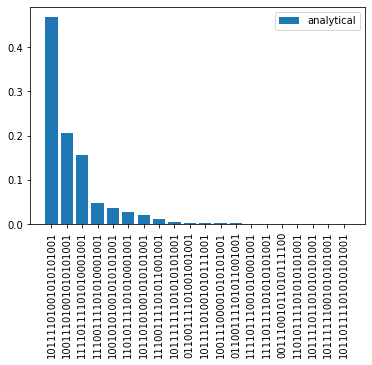

In [ ]:
states_nbit=states(num_spins=n_spins)
temp=0.4
boltz_prob_distn,bpd=true_boltzman_distn(n_spins, temp=temp, model=model, wanna_plot=True)#dict sorted in vals,dict sorted in keys
# plot_histogram([bpd], legend=["analytical"])

In [ ]:
mag_all_states=dict_magnetization_of_all_states(list_all_possible_states=states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=mag_all_states)
print("actual_avg_mag: ",actual_avg_mag)

actual_avg_mag:  1.758106510846588


### Function to run different number of mcmc chains for a particular problem instance

In [ ]:
# SOME UPDATED FUNCTIONS
def uncommon_els_2_lists(list_1,list_2):
  return list(set(list_1).symmetric_difference(set(list_2)))

def merge_2_dict(dict1, dict2):
    return({**dict1,**dict2})

def sort_dict_by_keys(dict_in:dict):
  from collections import OrderedDict
  return dict(OrderedDict(sorted(dict_in.items())))

# some changes in clasical mcmc
def classical_mcmc(
    N_hops: int,
    num_spins: int,
    initial_state: str,
    num_elems: int,
    model,
    return_last_n_states=500,
    return_both=False,
    temp=1,
):
    """
    Args:
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)
    model:
    return_last_n_states: (int) Number of states in the end of the M.Chain you want to consider for prob distn (default value is last 500)
    return_both (default=False): If set to True, in addition to dict_count_return_lst_n_states, also returns 2 lists:
                                "list_after_transition: list of states s' obtained after transition step s->s' " and
                                "list_after_acceptance_step: list of states accepted after the accepance step".
    Returns:
    Last 'dict_count_return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it!
    """
    states_obt = []
    # current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    current_state = initial_state
    print("starting with: ", current_state)
    states_obt.append(current_state)

    ## initialiiise observables
    # observable_dict = dict([ (elem, []) for elem in observables ])
    list_after_transition = []
    list_after_acceptance_step = []

    for i in tqdm(range(0, N_hops)):
        # get sprime
        s_prime = classical_transition(num_spins)
        list_after_transition.append(s_prime)
        # accept/reject s_prime
        energy_s = model.get_energy(current_state)
        energy_sprime = model.get_energy(s_prime)
        next_state = classical_loop_accepting_state(
            current_state, s_prime, energy_s, energy_sprime, temp=temp
        )
        current_state = next_state
        list_after_acceptance_step.append(current_state)
        states_obt.append(current_state)
        # WE DON;T NEED TO DO THIS! # reinitiate
        # qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)

    # returns dictionary of occurences for last "return_last_n_states" states
    ### added by neel 22-11-22
    all_possible_states_nbit=states(num_spins=num_spins)
    states_sampled=states_obt[-return_last_n_states:]
    states_not_obtained=uncommon_els_2_lists(all_possible_states_nbit, states_sampled)
    val_states_not_obtained=[0]*len(states_not_obtained)
    dict_states_not_obtained=dict(zip(states_not_obtained, val_states_not_obtained ))
    ### added by neel 22-11-22
    dict_count_return_last_n_states = merge_2_dict(dict(Counter(states_obt[-return_last_n_states:])), dict_states_not_obtained)

    if return_both:
        to_return = (
            dict_count_return_last_n_states,
            list_after_transition,
            list_after_acceptance_step,
        )
    else:
        to_return = dict_count_return_last_n_states

    return to_return

# some changes i quantum mcmc.
def quantum_enhanced_mcmc(
    N_hops: int,
    num_spins: int,
    initial_state: str,
    num_elems: int,
    model: IsingEnergyFunction,
    alpha,
    return_last_n_states=500,
    return_both=False,
    temp=1,
):
    """
    version 0.2
    Args:
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)
    model:
    alpha:
    return_last_n_states:
    return_both:
    temp:

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it!
    """
    states_obt = []
    print("starting with: ", initial_state)

    ## initialise quantum circuit to current_state
    qc_s = initialise_qc(n_spins=num_spins, bitstring=initial_state)
    current_state = initial_state
    states_obt.append(current_state)
    ## intialise observables
    list_after_transition = []
    list_after_acceptance_step = []

    for i in tqdm(range(0, N_hops)):
        # print("i: ", i)
        # get sprime
        s_prime = run_qc_quantum_step(
            qc_initialised_to_s=qc_s, model=model, alpha=alpha, n_spins=num_spins
        )
        list_after_transition.append(s_prime)
        # accept/reject s_prime
        energy_s = model.get_energy(current_state)
        energy_sprime = model.get_energy(s_prime)
        next_state = classical_loop_accepting_state(
            current_state, s_prime, energy_s, energy_sprime, temp=temp
        )
        current_state = next_state
        list_after_acceptance_step.append(current_state)
        states_obt.append(current_state)
        ## reinitiate
        qc_s = initialise_qc(n_spins=num_spins, bitstring=current_state)

    # dict_count_return_last_n_states = Counter(
    #     states[-return_last_n_states:]
    # )  # dictionary of occurences for last "return_last_n_states" states
    ### added by neel 22-11-22
    all_possible_states_nbit=states(num_spins=num_spins)
    states_sampled=states_obt[-return_last_n_states:]
    states_not_obtained=uncommon_els_2_lists(all_possible_states_nbit, states_sampled)
    val_states_not_obtained=[0]*len(states_not_obtained)
    dict_states_not_obtained=dict(zip(states_not_obtained, val_states_not_obtained ))
    ### added by neel 22-11-22
    dict_count_return_last_n_states = merge_2_dict(dict(Counter(states_obt[-return_last_n_states:])), dict_states_not_obtained)


    if return_both:
        to_return = (
            dict_count_return_last_n_states,
            list_after_transition,
            list_after_acceptance_step,
        )
    else:
        to_return = dict_count_return_last_n_states

    return to_return

In [ ]:
def run_mcmc_different_chains(num_spins:int, 
N_hops:int,num_seperate_mcmc_chains:int ,model,temp:float, 
return_last_n_states:int,return_both=False, is_quantum_mcmc=False, alpha=None ):

    num_elems=2**(num_spins)
    dict_seperate_chains_states_distn_mcmc={}
    dict_seperate_chains_sprime_mcmc={}
    dict_seperate_chains_accepted_mcmc={}
    dict_seperate_chains_counts_based_on_hamming_dist={}# we can get rid of these things
    dict_seperate_chains_energy_diff_s_and_sprime={}# for plotting histogram
    poss_states=list(range(0,num_elems))
    print(f"Whether running quantum mcmc: {is_quantum_mcmc}")
    for chain_num in tqdm(range(0,num_seperate_mcmc_chains)):
        init_state=np.random.choice(poss_states)
        poss_states.remove(init_state)# to ensure that each mcmc chain starts with a different initial state
        initial_state=f'{init_state:0{num_spins}b}'#f'{np.random.randint(0,num_elems):0{num_spins}b}'
        if is_quantum_mcmc:
            dict_states_mcmc, state_mcmc_after_trsn, state_mcmc_after_accept =quantum_enhanced_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                alpha,return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)
        else:
            dict_states_mcmc, state_mcmc_after_trsn, state_mcmc_after_accept =classical_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)                                                                        
        # sorting states in descending order of values(# occurences in mcmc chains)  for keys(states) 
        dict_states_mcmc_sorted_desc=value_sorted_dict(dict_states_mcmc, reverse=True)#dict_states_mcmc# this is where I might have to change things a little bit
        #storing in a dict
        dict_seperate_chains_states_distn_mcmc[chain_num]=dict_states_mcmc_sorted_desc
        dict_seperate_chains_sprime_mcmc[chain_num]=state_mcmc_after_trsn
        dict_seperate_chains_accepted_mcmc[chain_num]=state_mcmc_after_accept
        dict_seperate_chains_energy_diff_s_and_sprime[chain_num]=energy_difference_related_counts(num_spins, state_mcmc_after_trsn, state_mcmc_after_accept, model_in=model)
        dict_seperate_chains_counts_based_on_hamming_dist[chain_num]=hamming_dist_related_counts(num_spins, state_mcmc_after_trsn, state_mcmc_after_accept)

    return dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist


In [ ]:
# 10 seperate chains of classical mcmc for the given problem instance
N_hops=1000;num_seperate_mcmc_chains=4; return_last_n_states=N_hops
# later get rid of energy difference and hamming distance dicts.
dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist=run_mcmc_different_chains(n_spins, 
N_hops, num_seperate_mcmc_chains,
model, temp=temp, return_last_n_states=return_last_n_states,
return_both=True )

Whether running quantum mcmc: False


  0%|          | 0/4 [00:00<?, ?it/s]

starting with:  00001100110101100001



 25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

starting with:  01000001100000110111



 50%|█████     | 2/4 [00:04<00:04,  2.19s/it]

starting with:  11111000010000100111



 75%|███████▌  | 3/4 [00:06<00:02,  2.17s/it]

starting with:  00000011110111111101



100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


# TO DO:
get empirical distribution instead of count of occurence

In [ ]:
# kl divergence
# calculate the kl divergence
from math import log2
from math import sqrt
from numpy import asarray
import time 
def kl_divergence(p:list, q:list):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)) if p[i]!=0)

# calculate the js divergence
def js_divergence(dict_p:dict, dict_q:dict):
  p=asarray(list(dict_p.values())); q=asarray(list(dict_q.values()))
  m = 0.5 * (p + q)
  #print("m is:");print(m)
  return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

def running_js_divergence(list_chain_state_accepted:list, actual_boltz_distn:dict):
  num_nhops=len(list_chain_state_accepted)
  list_js_after_each_step=[]
  possible_states=list(actual_boltz_distn.keys())
  for step_num in tqdm(range(1,num_nhops)):
    print("step_num: ",step_num)
    t_i = time.process_time()
    #temp_distn_model=get_distn(list_chain_state_accepted[:step_num])
    ### added by me today:
    # 1. get list of unique elements in list_chain_state_accepted
    # 2. get list of allowed state not present in list_chain_state_accepted (list_states_not_present)
    # 3. create a temp_distn_model= 
    unique_els_list_of_accept_states=list(np.unique(list_chain_state_accepted[:step_num]))
    
    list_states_not_present=uncommon_els_2_lists(unique_els_list_of_accept_states,
                                                 possible_states)
    t1 = time.process_time()
    print("t_1:", t1 - t_i) ##cflag

    dict_states_not_obtained=dict(zip(list_states_not_present, [0]*len(list_states_not_present) ))
    temp_distn_model=merge_2_dict(get_distn(list_chain_state_accepted[:step_num]),dict_states_not_obtained)
    temp_distn_model=sort_dict_by_keys(temp_distn_model)#arranged in ascedning order of keys

    t2 = time.process_time()
    print("t_2:", t2 - t1) ##cflag
    #Merge(get_distn(list_chain_state_accepted[:step_num]), dict(zip()))
    # print("temp_distribution:")
    # print(temp_distn_model)
    # print(f"len(temp_distn_model):{len(temp_distn_model)}")
    
    #js divergence
    js_temp=js_divergence(actual_boltz_distn,temp_distn_model)

    # print(js_temp)
    list_js_after_each_step.append(js_temp)

    t3 = time.process_time()
    print("t_3:", t3 - t2) ##cflag

    #print(f"at step={step_num} of MCMC , KL Divergence: {js_temp}")
  return list_js_after_each_step

In [ ]:
len(chain_accepted_state)

1000

In [ ]:
list_running_js=[]
for i in range(0,num_seperate_mcmc_chains):# need to make this fast! it running very slowly rn
  # print("i:",i)
  chain_accepted_state=dict_seperate_chains_accepted_mcmc[i]
  running_js=running_js_divergence(chain_accepted_state,bpd)
  list_running_js.append(running_js)
  plt.figure()
  plt.plot(np.sqrt(running_js))
  plt.xlabel("mcmc steps")
  plt.ylabel("J-S Distance")

  0%|          | 0/999 [00:00<?, ?it/s]

step_num:  1
t_1: 0.24681886700000177
t_2: 3.4823304120000103


  0%|          | 1/999 [00:05<1:23:11,  5.00s/it]

t_3: 1.2889229479999358
step_num:  2
t_1: 0.2560485730000437
t_2: 3.498400585999889


  0%|          | 2/999 [00:10<1:23:27,  5.02s/it]

t_3: 1.291992657000037
step_num:  3
t_1: 0.28291574599984415
t_2: 3.495369768000046


  0%|          | 3/999 [00:15<1:23:13,  5.01s/it]

t_3: 1.2453098180001234
step_num:  4
t_1: 0.2616262579999784
t_2: 3.480060332999983


  0%|          | 4/999 [00:20<1:22:51,  5.00s/it]

t_3: 1.2421393570000419
step_num:  5
t_1: 0.26954590900004405
t_2: 3.404361525000013


  1%|          | 5/999 [00:24<1:22:27,  4.98s/it]

t_3: 1.2816790239999136
step_num:  6
t_1: 0.3019669069999509
t_2: 3.468194474000029


  1%|          | 6/999 [00:30<1:24:01,  5.08s/it]

t_3: 1.2404148329999316
step_num:  7
t_1: 0.2594931539999834
t_2: 3.5177306670000235


  1%|          | 7/999 [00:35<1:27:23,  5.29s/it]

t_3: 1.4218794070000058
step_num:  8
t_1: 0.25825006799982475
t_2: 3.589928600000121


  1%|          | 8/999 [00:41<1:27:18,  5.29s/it]

t_3: 1.283023987999968
step_num:  9
t_1: 0.2609076720000303
t_2: 3.3236621599999125


  1%|          | 9/999 [00:46<1:25:01,  5.15s/it]

t_3: 1.287285249000206
step_num:  10
t_1: 0.25928044499983116
t_2: 3.4186147130001245


  1%|          | 10/999 [00:51<1:23:42,  5.08s/it]

t_3: 1.2384689089999483
step_num:  11
t_1: 0.25646102600012455
t_2: 3.3539322699998593


  1%|          | 11/999 [00:55<1:22:37,  5.02s/it]

t_3: 1.2786289289999786
step_num:  12
t_1: 0.2539663449999807
t_2: 3.416132293999908


  1%|          | 12/999 [01:00<1:22:01,  4.99s/it]

t_3: 1.260184739000124
step_num:  13
t_1: 0.25775171999998747
t_2: 3.4434602929998164


  1%|▏         | 13/999 [01:05<1:22:10,  5.00s/it]

t_3: 1.3472733050000443
step_num:  14
t_1: 0.2584257839998827
t_2: 3.5058699210001123


  1%|▏         | 14/999 [01:10<1:22:06,  5.00s/it]

t_3: 1.2571235939999497
step_num:  15
t_1: 0.2508260680001513
t_2: 3.4802071869999054


  2%|▏         | 15/999 [01:15<1:21:55,  4.99s/it]

t_3: 1.2580874099999164
step_num:  16
t_1: 0.2708256649998475
t_2: 3.405479615000104


  2%|▏         | 16/999 [01:20<1:21:29,  4.97s/it]

t_3: 1.2604260559999148
step_num:  17
t_1: 0.2618292529998598
t_2: 3.3637212490000366


  2%|▏         | 17/999 [01:25<1:21:06,  4.96s/it]

t_3: 1.3013741810000283
step_num:  18
t_1: 0.2617403249998915
t_2: 3.426532105999968


  2%|▏         | 18/999 [01:30<1:21:12,  4.97s/it]

t_3: 1.3159156040001108
step_num:  19
t_1: 0.25528463299997384
t_2: 3.44202062699992


  2%|▏         | 19/999 [01:35<1:21:11,  4.97s/it]

t_3: 1.2962380500000563
step_num:  20
t_1: 0.25672631399993406
t_2: 3.4771997499999543


  2%|▏         | 20/999 [01:40<1:21:10,  4.97s/it]

t_3: 1.2598985130000528
step_num:  21
t_1: 0.25473884899997756
t_2: 3.4817441279999457


  2%|▏         | 21/999 [01:45<1:21:06,  4.98s/it]

t_3: 1.2570967610001844
step_num:  22
t_1: 0.25397886399991876
t_2: 3.39509219699994


  2%|▏         | 22/999 [01:50<1:20:32,  4.95s/it]

t_3: 1.2435899459999291
step_num:  23
t_1: 0.26502848599966455
t_2: 3.410173018000023


  2%|▏         | 23/999 [01:55<1:20:21,  4.94s/it]

t_3: 1.2667293040003642
step_num:  24
t_1: 0.2563264690002143
t_2: 3.431180263999977


  2%|▏         | 24/999 [02:00<1:20:21,  4.94s/it]

t_3: 1.2726863610000692
step_num:  25
t_1: 0.26111785099965346
t_2: 3.4351926829999684


  3%|▎         | 25/999 [02:05<1:20:12,  4.94s/it]

t_3: 1.2533398020000277
step_num:  26
t_1: 0.26018979899981787
t_2: 3.5224865780000982


  3%|▎         | 26/999 [02:10<1:20:50,  4.98s/it]

t_3: 1.298623705999944
step_num:  27
t_1: 0.25653659699992204
t_2: 3.446951680999973


  3%|▎         | 27/999 [02:15<1:20:35,  4.97s/it]

t_3: 1.2647568259999389
step_num:  28
t_1: 0.2563171480001074
t_2: 3.4642212859998835


  3%|▎         | 28/999 [02:20<1:20:27,  4.97s/it]

t_3: 1.2573555079998187
step_num:  29
t_1: 0.26012976799984244
t_2: 3.372647211000185


  3%|▎         | 29/999 [02:25<1:19:51,  4.94s/it]

t_3: 1.2456729179998547
step_num:  30
t_1: 0.2554555110000365
t_2: 3.367303480999908


  3%|▎         | 30/999 [02:29<1:19:20,  4.91s/it]

t_3: 1.238504954000291
step_num:  31
t_1: 0.24862828899995293
t_2: 3.367018907000329


  3%|▎         | 31/999 [02:34<1:18:58,  4.90s/it]

t_3: 1.2522196309996616
step_num:  32
t_1: 0.26068541899985576
t_2: 3.4312567410001975


  3%|▎         | 32/999 [02:39<1:19:02,  4.90s/it]

t_3: 1.2441010029997415
step_num:  33
t_1: 0.24855606699975397
t_2: 3.3489073030000327


  3%|▎         | 33/999 [02:44<1:18:49,  4.90s/it]

t_3: 1.2871393980003631
step_num:  34
t_1: 0.2518577929999992
t_2: 3.4038251550000496


  3%|▎         | 34/999 [02:49<1:18:42,  4.89s/it]

t_3: 1.2471662749999268
step_num:  35
t_1: 0.2494167429999834
t_2: 3.4161969850001697


  4%|▎         | 35/999 [02:54<1:18:48,  4.90s/it]

t_3: 1.269178606999958
step_num:  36
t_1: 0.251462624999931
t_2: 3.378552789999958


  4%|▎         | 36/999 [02:59<1:18:35,  4.90s/it]

t_3: 1.2681871120003052
step_num:  37
t_1: 0.2613963670000885
t_2: 3.385734195999703


  4%|▎         | 37/999 [03:04<1:18:31,  4.90s/it]

t_3: 1.2651019710001492
step_num:  38
t_1: 0.2470188259999304
t_2: 3.3787178210000093


  4%|▍         | 38/999 [03:09<1:18:19,  4.89s/it]

t_3: 1.2577079840002625
step_num:  39
t_1: 0.25251338899988696
t_2: 3.334168329000022


  4%|▍         | 39/999 [03:13<1:18:08,  4.88s/it]

t_3: 1.2919326319997708
step_num:  40
t_1: 0.25229424799999833
t_2: 3.33311176899997


  4%|▍         | 40/999 [03:18<1:17:46,  4.87s/it]

t_3: 1.2624704579998252
step_num:  41
t_1: 0.2510432409999339
t_2: 3.249098274000062


  4%|▍         | 41/999 [03:23<1:17:13,  4.84s/it]

t_3: 1.2755410350000602
step_num:  42
t_1: 0.24836632100004863
t_2: 3.37319923799987


  4%|▍         | 42/999 [03:28<1:17:22,  4.85s/it]

t_3: 1.2721537500001432
step_num:  43
t_1: 0.2539061549996404
t_2: 3.3096774180003194


  4%|▍         | 43/999 [03:33<1:17:13,  4.85s/it]

t_3: 1.2878038740000193
step_num:  44
t_1: 0.25238726599991423
t_2: 3.3212967389999903


  4%|▍         | 44/999 [03:38<1:17:24,  4.86s/it]

t_3: 1.3337817050000922
step_num:  45
t_1: 0.259386749999976
t_2: 3.4219020450000244


  5%|▍         | 45/999 [03:43<1:17:52,  4.90s/it]

t_3: 1.3087034889999813
step_num:  46
t_1: 0.26047849599990514
t_2: 3.490050870000232


  5%|▍         | 46/999 [03:48<1:18:30,  4.94s/it]

t_3: 1.3129073919999428
step_num:  47
t_1: 0.272608142000081
t_2: 3.4477580289999423


  5%|▍         | 47/999 [03:53<1:18:49,  4.97s/it]

t_3: 1.3286913430001732
step_num:  48
t_1: 0.2676653069997883
t_2: 3.490905715000281


  5%|▍         | 48/999 [03:58<1:18:58,  4.98s/it]

t_3: 1.2779393349997008
step_num:  49
t_1: 0.2700514579996707
t_2: 3.4606899610002984


  5%|▍         | 49/999 [04:03<1:19:03,  4.99s/it]

t_3: 1.307769972999722
step_num:  50
t_1: 0.25230901499980973
t_2: 3.4507312420000744


  5%|▌         | 50/999 [04:08<1:19:03,  5.00s/it]

t_3: 1.3185770519999096
step_num:  51
t_1: 0.2657716500002607
t_2: 3.458223784999973


  5%|▌         | 51/999 [04:13<1:19:11,  5.01s/it]

t_3: 1.3411722709997775
step_num:  52
t_1: 0.2556658570001673
t_2: 3.4468700150000586


  5%|▌         | 52/999 [04:18<1:19:00,  5.01s/it]

t_3: 1.2948526850000235
step_num:  53
t_1: 0.2524635039999339
t_2: 3.359862681999857


  5%|▌         | 53/999 [04:23<1:18:33,  4.98s/it]

t_3: 1.3220403889999943
step_num:  54
t_1: 0.25932741899987377
t_2: 3.476103005999903


  5%|▌         | 54/999 [04:28<1:18:40,  5.00s/it]

t_3: 1.295013297999958
step_num:  55
t_1: 0.253939747000004
t_2: 3.479119001000072


  6%|▌         | 55/999 [04:33<1:18:32,  4.99s/it]

t_3: 1.26636260999976
step_num:  56
t_1: 0.2598480810002002
t_2: 3.4268256049999763


  6%|▌         | 56/999 [04:38<1:18:37,  5.00s/it]

t_3: 1.3487601840001844
step_num:  57
t_1: 0.2609254469998632
t_2: 3.493015886000194


  6%|▌         | 57/999 [04:43<1:18:46,  5.02s/it]

t_3: 1.309130082000138
step_num:  58
t_1: 0.25312141199992766
t_2: 3.4862111209999966


  6%|▌         | 58/999 [04:48<1:18:35,  5.01s/it]

t_3: 1.2711155790002522
step_num:  59
t_1: 0.26512283899955946
t_2: 3.5257090790000802


  6%|▌         | 59/999 [04:53<1:18:50,  5.03s/it]

t_3: 1.3066433090002647
step_num:  60
t_1: 0.2529544259996328
t_2: 3.5115466470001593


  6%|▌         | 60/999 [04:58<1:18:48,  5.04s/it]

t_3: 1.2975229710000349
step_num:  61
t_1: 0.26074296199976743
t_2: 3.515660311999909


  6%|▌         | 61/999 [05:03<1:19:06,  5.06s/it]

t_3: 1.3492743340002562
step_num:  62
t_1: 0.26166254700001446
t_2: 3.56294772199999


  6%|▌         | 62/999 [05:08<1:19:12,  5.07s/it]

t_3: 1.2961304180003026
step_num:  63
t_1: 0.26556479700002456
t_2: 3.5832877329999064


  6%|▋         | 63/999 [05:13<1:19:38,  5.11s/it]

t_3: 1.3523801810001714
step_num:  64
t_1: 0.25751030599985825
t_2: 3.494378463999965


  6%|▋         | 64/999 [05:18<1:19:10,  5.08s/it]

t_3: 1.2882561650003481
step_num:  65
t_1: 0.2508077960001174
t_2: 3.4149034729998675


  7%|▋         | 65/999 [05:23<1:18:26,  5.04s/it]

t_3: 1.2813564819998646
step_num:  66
t_1: 0.2623716630000672
t_2: 3.47338447500033


  7%|▋         | 66/999 [05:28<1:18:07,  5.02s/it]

t_3: 1.2726150139997117
step_num:  67
t_1: 0.2667604640000718
t_2: 3.469782675999795


  7%|▋         | 67/999 [05:33<1:17:46,  5.01s/it]

t_3: 1.2457331240002532
step_num:  68
t_1: 0.24942207999993116
t_2: 3.3748614129999623


  7%|▋         | 68/999 [05:38<1:17:10,  4.97s/it]

t_3: 1.2888285260000885
step_num:  69
t_1: 0.25121085299997503
t_2: 3.4193630899999334


  7%|▋         | 69/999 [05:43<1:17:03,  4.97s/it]

t_3: 1.3134082999999919
step_num:  70
t_1: 0.25714077600014207
t_2: 3.3482147069998973


  7%|▋         | 70/999 [05:48<1:16:40,  4.95s/it]

t_3: 1.325837158000013
step_num:  71
t_1: 0.2581884109999919
t_2: 3.389910986999894


  7%|▋         | 71/999 [05:53<1:16:30,  4.95s/it]

t_3: 1.3035628259999612
step_num:  72
t_1: 0.2515644989998691
t_2: 3.3926622920002956


  7%|▋         | 72/999 [05:58<1:16:11,  4.93s/it]

t_3: 1.2674781350001467
step_num:  73
t_1: 0.2617309209999803
t_2: 3.4559368499999437


  7%|▋         | 73/999 [06:03<1:16:23,  4.95s/it]

t_3: 1.2848586179998165
step_num:  74
t_1: 0.27117081500000495
t_2: 3.4725179689999095


  7%|▋         | 74/999 [06:08<1:16:41,  4.97s/it]

t_3: 1.2956857569997737
step_num:  75
t_1: 0.2559497980000742
t_2: 3.541142518000015


  8%|▊         | 75/999 [06:13<1:17:03,  5.00s/it]

t_3: 1.2945006529998864
step_num:  76
t_1: 0.24773421400004736
t_2: 3.4386231399998906


  8%|▊         | 76/999 [06:18<1:16:39,  4.98s/it]

t_3: 1.2611999609998747
step_num:  77
t_1: 0.2659292169996661
t_2: 3.4273982630002138


  8%|▊         | 77/999 [06:23<1:16:32,  4.98s/it]

t_3: 1.2936909119998745
step_num:  78
t_1: 0.2558917100000144
t_2: 3.4643016009999883


  8%|▊         | 78/999 [06:28<1:16:20,  4.97s/it]

t_3: 1.2566063300000678
step_num:  79
t_1: 0.2533134320001409
t_2: 3.4605054220000966


  8%|▊         | 79/999 [06:33<1:16:12,  4.97s/it]

t_3: 1.2619585560000814
step_num:  80
t_1: 0.24899585299999671
t_2: 3.4546417500000643


  8%|▊         | 80/999 [06:38<1:16:11,  4.97s/it]

t_3: 1.285352994999812
step_num:  81
t_1: 0.2529709630002799
t_2: 3.3897954660001233


  8%|▊         | 81/999 [06:43<1:15:42,  4.95s/it]

t_3: 1.2585523029997603
step_num:  82
t_1: 0.25721703199997137
t_2: 3.360838898000111


  8%|▊         | 82/999 [06:48<1:15:19,  4.93s/it]

t_3: 1.2809317219998775
step_num:  83
t_1: 0.25792188900004476
t_2: 3.423479755000244


  8%|▊         | 83/999 [06:52<1:15:06,  4.92s/it]

t_3: 1.2365751669999554
step_num:  84
t_1: 0.251683741999841
t_2: 3.345561751999867


  8%|▊         | 84/999 [06:57<1:14:46,  4.90s/it]

t_3: 1.2779165940000894
step_num:  85
t_1: 0.2509066249999705
t_2: 3.3751238579998244


  9%|▊         | 85/999 [07:02<1:14:55,  4.92s/it]

t_3: 1.3382125190000806
step_num:  86
t_1: 0.25449889099991196
t_2: 3.3550669539999944


  9%|▊         | 86/999 [07:07<1:14:42,  4.91s/it]

t_3: 1.2936561050000819
step_num:  87
t_1: 0.25676182999995945
t_2: 3.3820787760000712


  9%|▊         | 87/999 [07:12<1:14:30,  4.90s/it]

t_3: 1.2622019010000258
step_num:  88
t_1: 0.2556811790000211
t_2: 3.463625595999929


  9%|▉         | 88/999 [07:17<1:14:47,  4.93s/it]

t_3: 1.272662672000024
step_num:  89
t_1: 0.25263948300016636
t_2: 3.4376984330001505


  9%|▉         | 89/999 [07:22<1:14:47,  4.93s/it]

t_3: 1.2626498039999206
step_num:  90
t_1: 0.24388045500018052
t_2: 3.405668502000026


  9%|▉         | 90/999 [07:27<1:14:31,  4.92s/it]

t_3: 1.2554956789999778
step_num:  91
t_1: 0.2528858880000371
t_2: 3.3538168119998772


  9%|▉         | 91/999 [07:32<1:14:17,  4.91s/it]

t_3: 1.2839276370000334
step_num:  92
t_1: 0.2530261470001278
t_2: 3.3508819210001093


  9%|▉         | 92/999 [07:37<1:14:14,  4.91s/it]

t_3: 1.3126541809997434
step_num:  93
t_1: 0.2604293389999839
t_2: 3.325594744999762


  9%|▉         | 93/999 [07:42<1:14:02,  4.90s/it]

t_3: 1.3100882200001251
step_num:  94
t_1: 0.25210890100015604
t_2: 3.5068537359998118


  9%|▉         | 94/999 [07:47<1:14:33,  4.94s/it]

t_3: 1.2609381699999176
step_num:  95
t_1: 0.26309577599977274
t_2: 3.375716965000265


 10%|▉         | 95/999 [07:52<1:14:20,  4.93s/it]

t_3: 1.2898765739996634
step_num:  96
t_1: 0.2402252890001364
t_2: 3.363286369999969


 10%|▉         | 96/999 [07:56<1:13:53,  4.91s/it]

t_3: 1.2578174279997256
step_num:  97
t_1: 0.24682527899994966
t_2: 3.3242697559999215


 10%|▉         | 97/999 [08:01<1:13:28,  4.89s/it]

t_3: 1.2751790500001334
step_num:  98
t_1: 0.25732792700000573
t_2: 3.453031581000232


 10%|▉         | 98/999 [08:06<1:13:39,  4.90s/it]

t_3: 1.2458011159997113
step_num:  99
t_1: 0.2585883339997963
t_2: 3.4042141490003814


 10%|▉         | 99/999 [08:11<1:13:35,  4.91s/it]

t_3: 1.2640036610000607
step_num:  100
t_1: 0.25374484200028746
t_2: 3.447537997999916


 10%|█         | 100/999 [08:16<1:13:34,  4.91s/it]

t_3: 1.2346111520000704
step_num:  101
t_1: 0.25806648800016774
t_2: 3.459126144000038


 10%|█         | 101/999 [08:21<1:13:45,  4.93s/it]

t_3: 1.2673492740000256
step_num:  102
t_1: 0.253349550999701
t_2: 3.4761736600003132


 10%|█         | 102/999 [08:26<1:13:54,  4.94s/it]

t_3: 1.262185715999749
step_num:  103
t_1: 0.2600770349999948
t_2: 3.4738686140003665


 10%|█         | 103/999 [08:31<1:13:58,  4.95s/it]

t_3: 1.2484556199997314
step_num:  104
t_1: 0.2550797760000023
t_2: 3.4605126980000023


 10%|█         | 104/999 [08:36<1:13:58,  4.96s/it]

t_3: 1.2646993170001224
step_num:  105
t_1: 0.2573612520000097
t_2: 3.4034303510002246


 11%|█         | 105/999 [08:41<1:13:38,  4.94s/it]

t_3: 1.2545891209997535
step_num:  106
t_1: 0.2611170420000235
t_2: 3.412615500999891


 11%|█         | 106/999 [08:46<1:13:40,  4.95s/it]

t_3: 1.3145118610000281
step_num:  107
t_1: 0.2554228190001595
t_2: 3.37048684399997


 11%|█         | 107/999 [08:51<1:13:25,  4.94s/it]

t_3: 1.299687979999817
step_num:  108
t_1: 0.2521132000001671
t_2: 3.392584498999895


 11%|█         | 108/999 [08:56<1:13:13,  4.93s/it]

t_3: 1.2877137169998605
step_num:  109
t_1: 0.25045170100020187
t_2: 3.4271965930001898


 11%|█         | 109/999 [09:01<1:13:15,  4.94s/it]

t_3: 1.2827874589997919
step_num:  110
t_1: 0.25146448200030136
t_2: 3.485680258999764


 11%|█         | 110/999 [09:06<1:13:25,  4.96s/it]

t_3: 1.2732698350000646
step_num:  111
t_1: 0.260581927000203
t_2: 3.466526192999936


 11%|█         | 111/999 [09:11<1:13:29,  4.97s/it]

t_3: 1.2660344020000593
step_num:  112
t_1: 0.2543083589998787
t_2: 3.3789254810003513


 11%|█         | 112/999 [09:15<1:13:07,  4.95s/it]

t_3: 1.289509753999937
step_num:  113
t_1: 0.2513589079999292
t_2: 3.410805554000035


 11%|█▏        | 113/999 [09:20<1:12:48,  4.93s/it]

t_3: 1.2458237480000207
step_num:  114
t_1: 0.26242404899994654
t_2: 3.383332413000062


 11%|█▏        | 114/999 [09:25<1:12:38,  4.92s/it]

t_3: 1.2778680930000519
step_num:  115
t_1: 0.2559478670000317
t_2: 3.452199538000059


 12%|█▏        | 115/999 [09:30<1:12:54,  4.95s/it]

t_3: 1.3041158569999425
step_num:  116
t_1: 0.24655362200019226
t_2: 3.418225082999925


 12%|█▏        | 116/999 [09:35<1:12:47,  4.95s/it]

t_3: 1.2860730239999612
step_num:  117
t_1: 0.25174378400015485
t_2: 3.445224959999905


 12%|█▏        | 117/999 [09:40<1:13:00,  4.97s/it]

t_3: 1.3296064119999755
step_num:  118
t_1: 0.24829802799968093
t_2: 3.4381306000000222


 12%|█▏        | 118/999 [09:45<1:12:58,  4.97s/it]

t_3: 1.3080513180002526
step_num:  119
t_1: 0.25928323500011174
t_2: 3.3880698829998437


 12%|█▏        | 119/999 [09:50<1:12:48,  4.96s/it]

t_3: 1.3190513570002622
step_num:  120
t_1: 0.25448255900028016
t_2: 3.3579797919996963


 12%|█▏        | 120/999 [09:55<1:12:19,  4.94s/it]

t_3: 1.2806266440002219
step_num:  121
t_1: 0.25874782900018545
t_2: 3.340064194000206


 12%|█▏        | 121/999 [10:00<1:12:03,  4.92s/it]

t_3: 1.3055505229999653
step_num:  122
t_1: 0.2575616560002345
t_2: 3.4385369799997534


 12%|█▏        | 122/999 [10:05<1:12:02,  4.93s/it]

t_3: 1.2594891329999882
step_num:  123
t_1: 0.2630831000001308
t_2: 3.434277834999648


 12%|█▏        | 123/999 [10:10<1:12:00,  4.93s/it]

t_3: 1.2551254770000924
step_num:  124
t_1: 0.254972885999905
t_2: 3.4489588259998527


 12%|█▏        | 124/999 [10:15<1:11:51,  4.93s/it]

t_3: 1.2318026570001166
step_num:  125
t_1: 0.25345003900019947
t_2: 3.4914355089999844


 13%|█▎        | 125/999 [10:20<1:12:06,  4.95s/it]

t_3: 1.2721359450001728
step_num:  126
t_1: 0.2511788750002779
t_2: 3.407842477000031


 13%|█▎        | 126/999 [10:25<1:11:50,  4.94s/it]

t_3: 1.2699870349997582
step_num:  127
t_1: 0.25135120499999175
t_2: 3.403913560000092


 13%|█▎        | 127/999 [10:30<1:11:45,  4.94s/it]

t_3: 1.2986095390001537
step_num:  128
t_1: 0.2594108030002644
t_2: 3.4988137699997424


 13%|█▎        | 128/999 [10:35<1:11:55,  4.95s/it]

t_3: 1.2470422710002822
step_num:  129
t_1: 0.26019066100025157
t_2: 3.3627461769997353


 13%|█▎        | 129/999 [10:39<1:11:35,  4.94s/it]

t_3: 1.293292547999954
step_num:  130
t_1: 0.24714841300010448
t_2: 3.4088867509999545


 13%|█▎        | 130/999 [10:44<1:11:17,  4.92s/it]

t_3: 1.2502829539998856
step_num:  131
t_1: 0.24815297699979055
t_2: 3.424806066000201


 13%|█▎        | 131/999 [10:49<1:11:09,  4.92s/it]

t_3: 1.2539526329996988
step_num:  132
t_1: 0.2523560540003018
t_2: 3.35551168999973


 13%|█▎        | 132/999 [10:54<1:10:50,  4.90s/it]

t_3: 1.2693502870001794
step_num:  133
t_1: 0.2466509739997491
t_2: 3.3420053530003315


 13%|█▎        | 133/999 [10:59<1:10:28,  4.88s/it]

t_3: 1.2558598709997568
step_num:  134
t_1: 0.2588582379999025
t_2: 3.3876822140000513


 13%|█▎        | 134/999 [11:04<1:10:29,  4.89s/it]

t_3: 1.2639799049998146
step_num:  135
t_1: 0.25708677899956456
t_2: 3.3634810220000873


 14%|█▎        | 135/999 [11:09<1:10:27,  4.89s/it]

t_3: 1.2994391639999776
step_num:  136
t_1: 0.25338004199966235
t_2: 3.3573913100003665


 14%|█▎        | 136/999 [11:14<1:10:13,  4.88s/it]

t_3: 1.2714048709999588
step_num:  137
t_1: 0.2538064069999564
t_2: 3.3530646470003376


 14%|█▎        | 137/999 [11:18<1:10:10,  4.88s/it]

t_3: 1.2978872169996976
step_num:  138
t_1: 0.25283234700009416
t_2: 3.383585608999965


 14%|█▍        | 138/999 [11:23<1:10:08,  4.89s/it]

t_3: 1.2698508980001861
step_num:  139
t_1: 0.26624365499992564
t_2: 3.414453253999909


 14%|█▍        | 139/999 [11:28<1:10:14,  4.90s/it]

t_3: 1.2643464279999534
step_num:  140
t_1: 0.25738074899982166
t_2: 3.414313246999882


 14%|█▍        | 140/999 [11:33<1:10:18,  4.91s/it]

t_3: 1.2757322160000513
step_num:  141
t_1: 0.2526896599997599
t_2: 3.442774689000089


 14%|█▍        | 141/999 [11:38<1:10:26,  4.93s/it]

t_3: 1.2848671699998704
step_num:  142
t_1: 0.260390231999736
t_2: 3.3938936710001144


 14%|█▍        | 142/999 [11:43<1:10:21,  4.93s/it]

t_3: 1.2781074210001862
step_num:  143
t_1: 0.2564380830003756
t_2: 3.485328580999976


 14%|█▍        | 143/999 [11:48<1:10:36,  4.95s/it]

t_3: 1.2715648250000413
step_num:  144
t_1: 0.2570032550001997
t_2: 3.4414514079999208


 14%|█▍        | 144/999 [11:53<1:10:45,  4.97s/it]

t_3: 1.314244386000155
step_num:  145
t_1: 0.2533805940001912
t_2: 3.450443175000146


 15%|█▍        | 145/999 [11:58<1:10:37,  4.96s/it]

t_3: 1.2714493700000276
step_num:  146
t_1: 0.2578082869999889
t_2: 3.3980999120003617


 15%|█▍        | 146/999 [12:03<1:10:26,  4.95s/it]

t_3: 1.3021913570000834
step_num:  147
t_1: 0.2593942779999452
t_2: 3.4391612750000604


 15%|█▍        | 147/999 [12:08<1:10:20,  4.95s/it]

t_3: 1.2718113890000495
step_num:  148
t_1: 0.2563470199997937
t_2: 3.4362121500003013


 15%|█▍        | 148/999 [12:13<1:10:09,  4.95s/it]

t_3: 1.2496623129995896
step_num:  149
t_1: 0.2534307959999751
t_2: 3.359794625000177


 15%|█▍        | 149/999 [12:18<1:09:48,  4.93s/it]

t_3: 1.281076356000085
step_num:  150
t_1: 0.25497323099989444
t_2: 3.4174280229999567


 15%|█▌        | 150/999 [12:23<1:09:41,  4.92s/it]

t_3: 1.2619456299999001
step_num:  151
t_1: 0.25596007900003315
t_2: 3.4149104990001433


 15%|█▌        | 151/999 [12:28<1:09:39,  4.93s/it]

t_3: 1.2831604479997623
step_num:  152
t_1: 0.25455323100004534
t_2: 3.571699281000292


 15%|█▌        | 152/999 [12:33<1:10:12,  4.97s/it]

t_3: 1.267801443999815
step_num:  153
t_1: 0.2512809200002266
t_2: 3.364633152999886


 15%|█▌        | 153/999 [12:38<1:09:47,  4.95s/it]

t_3: 1.298349145999964
step_num:  154
t_1: 0.2574088979999942
t_2: 3.5062224979997154


 15%|█▌        | 154/999 [12:43<1:10:02,  4.97s/it]

t_3: 1.273061348000283
step_num:  155
t_1: 0.2620597159998397
t_2: 3.5766576190003434


 16%|█▌        | 155/999 [12:48<1:10:28,  5.01s/it]

t_3: 1.2736772799999017
step_num:  156
t_1: 0.2656818079999539
t_2: 3.601385222999852


 16%|█▌        | 156/999 [12:53<1:10:57,  5.05s/it]

t_3: 1.287076307999996
step_num:  157
t_1: 0.279047074999653
t_2: 3.5316905070003486


 16%|█▌        | 157/999 [12:58<1:10:52,  5.05s/it]

t_3: 1.2580447279997315
step_num:  158
t_1: 0.26523915000007037
t_2: 3.5921517989995664


 16%|█▌        | 158/999 [13:03<1:11:19,  5.09s/it]

t_3: 1.3312775540002804
step_num:  159
t_1: 0.26260758399985207
t_2: 3.618360495000161


 16%|█▌        | 159/999 [13:08<1:11:40,  5.12s/it]

t_3: 1.3313714219998474
step_num:  160
t_1: 0.26375570800018977
t_2: 3.4177482599998257


 16%|█▌        | 160/999 [13:13<1:10:50,  5.07s/it]

t_3: 1.2693231739999646
step_num:  161
t_1: 0.25558321400012574
t_2: 3.394742090999898


 16%|█▌        | 161/999 [13:18<1:10:10,  5.02s/it]

t_3: 1.286451640999985
step_num:  162
t_1: 0.25335780799969143
t_2: 3.4748286660001213


 16%|█▌        | 162/999 [13:23<1:09:55,  5.01s/it]

t_3: 1.2724801660001503
step_num:  163
t_1: 0.2476570349999747
t_2: 3.4258576739998716


 16%|█▋        | 163/999 [13:28<1:09:27,  4.99s/it]

t_3: 1.268444762999934
step_num:  164
t_1: 0.25649447700016026
t_2: 3.4053730239998004


 16%|█▋        | 164/999 [13:33<1:09:10,  4.97s/it]

t_3: 1.2907449419999466
step_num:  165
t_1: 0.2576486580001074
t_2: 3.4931863199999498


 17%|█▋        | 165/999 [13:38<1:09:24,  4.99s/it]

t_3: 1.313229895999939
step_num:  166
t_1: 0.2568840949998048
t_2: 3.500348774000031


 17%|█▋        | 166/999 [13:43<1:09:23,  5.00s/it]

t_3: 1.265001205000317
step_num:  167
t_1: 0.25612419900016903
t_2: 3.473859480000101


 17%|█▋        | 167/999 [13:48<1:09:22,  5.00s/it]

t_3: 1.302220084000055
step_num:  168
t_1: 0.255769687999873
t_2: 3.528534640000089


 17%|█▋        | 168/999 [13:53<1:09:23,  5.01s/it]

t_3: 1.257862025999657
step_num:  169
t_1: 0.2657891210001253
t_2: 3.469092117999935


 17%|█▋        | 169/999 [13:58<1:09:25,  5.02s/it]

t_3: 1.3135786739999276
step_num:  170
t_1: 0.2576492979997056
t_2: 3.567983465999987


 17%|█▋        | 170/999 [14:03<1:09:42,  5.05s/it]

t_3: 1.2965349310002239
step_num:  171
t_1: 0.26365618399995583
t_2: 3.5520495169998867


 17%|█▋        | 171/999 [14:08<1:09:48,  5.06s/it]

t_3: 1.2956034170001658
step_num:  172
t_1: 0.2612066289998438
t_2: 3.5664108940000006


 17%|█▋        | 172/999 [14:13<1:09:45,  5.06s/it]

t_3: 1.2505090149998068
step_num:  173
t_1: 0.2637048149999828
t_2: 3.4979004100000566


 17%|█▋        | 173/999 [14:18<1:09:37,  5.06s/it]

t_3: 1.3061414740000146
step_num:  174
t_1: 0.25807347299996763
t_2: 3.5672162500000013


 17%|█▋        | 174/999 [14:24<1:09:32,  5.06s/it]

t_3: 1.2411999250002737
step_num:  175
t_1: 0.2597549230004006
t_2: 3.4991272729998855


 18%|█▊        | 175/999 [14:29<1:09:14,  5.04s/it]

t_3: 1.2606093300000794
step_num:  176
t_1: 0.25845497199998135
t_2: 3.372073601000011


 18%|█▊        | 176/999 [14:33<1:08:36,  5.00s/it]

t_3: 1.2872076610001386
step_num:  177
t_1: 0.2506333110000014
t_2: 3.3688000439997268


 18%|█▊        | 177/999 [14:38<1:08:08,  4.97s/it]

t_3: 1.3010832760000994
step_num:  178
t_1: 0.25443145899998854
t_2: 3.3640516880000177


 18%|█▊        | 178/999 [14:43<1:07:35,  4.94s/it]

t_3: 1.2462857649998114
step_num:  179
t_1: 0.2521961019997434
t_2: 3.3338996900001803


 18%|█▊        | 179/999 [14:48<1:06:58,  4.90s/it]

t_3: 1.2375773359999584
step_num:  180
t_1: 0.2579220229999919
t_2: 3.3392576080000254


 18%|█▊        | 180/999 [14:53<1:06:43,  4.89s/it]

t_3: 1.27636511899982
step_num:  181
t_1: 0.2518867290000344
t_2: 3.335021577000134


 18%|█▊        | 181/999 [14:58<1:06:22,  4.87s/it]

t_3: 1.2479109440000684
step_num:  182
t_1: 0.24962380299984943
t_2: 3.4050453340000786


 18%|█▊        | 182/999 [15:03<1:06:27,  4.88s/it]

t_3: 1.2659862669997892
step_num:  183
t_1: 0.2603332580001734
t_2: 3.440495763999934


 18%|█▊        | 183/999 [15:08<1:06:53,  4.92s/it]

t_3: 1.3046062260000326
step_num:  184
t_1: 0.24934972900018693
t_2: 3.406973457999811


 18%|█▊        | 184/999 [15:13<1:06:47,  4.92s/it]

t_3: 1.2734435130000747
step_num:  185
t_1: 0.25455020499975944
t_2: 3.373471772999892


 19%|█▊        | 185/999 [15:17<1:06:30,  4.90s/it]

t_3: 1.2418606720002572
step_num:  186
t_1: 0.25885198899959505
t_2: 3.318439285000295


 19%|█▊        | 186/999 [15:22<1:06:19,  4.89s/it]

t_3: 1.3119766149998213
step_num:  187
t_1: 0.25475572899995313
t_2: 3.523901331000161


 19%|█▊        | 187/999 [15:27<1:07:04,  4.96s/it]

t_3: 1.3343618750000132
step_num:  188
t_1: 0.25244933500016487
t_2: 3.519120510999983


 19%|█▉        | 188/999 [15:32<1:07:21,  4.98s/it]

t_3: 1.2880047059998105
step_num:  189
t_1: 0.25962866100007886
t_2: 3.5887340429999313


 19%|█▉        | 189/999 [15:38<1:07:47,  5.02s/it]

t_3: 1.2795537670003796
step_num:  190
t_1: 0.2557113349998872
t_2: 3.5152936680001403


 19%|█▉        | 190/999 [15:43<1:07:40,  5.02s/it]

t_3: 1.2571020840000529
step_num:  191
t_1: 0.25184546399987084
t_2: 3.3362043689999155


 19%|█▉        | 191/999 [15:47<1:06:52,  4.97s/it]

t_3: 1.269021463000172
step_num:  192
t_1: 0.2648097650003365
t_2: 3.361737743000049


 19%|█▉        | 192/999 [15:52<1:06:45,  4.96s/it]

t_3: 1.3419842849998531
step_num:  193
t_1: 0.24922207000008711
t_2: 3.3641147560001627


 19%|█▉        | 193/999 [15:57<1:06:16,  4.93s/it]

t_3: 1.265657076000025
step_num:  194
t_1: 0.2606191019999642
t_2: 3.3247418240002844


 19%|█▉        | 194/999 [16:02<1:05:47,  4.90s/it]

t_3: 1.2663554349996957
step_num:  195
t_1: 0.2618797499999346
t_2: 3.445911727999828


 20%|█▉        | 195/999 [16:07<1:06:06,  4.93s/it]

t_3: 1.316417265000382
step_num:  196
t_1: 0.2551977729999635
t_2: 3.4813593139997465


 20%|█▉        | 196/999 [16:12<1:06:19,  4.96s/it]

t_3: 1.2882907880002676
step_num:  197
t_1: 0.24881400500044037
t_2: 3.5136408439998377


 20%|█▉        | 197/999 [16:17<1:06:28,  4.97s/it]

t_3: 1.2680462429998443
step_num:  198
t_1: 0.25112175499998557
t_2: 3.503318679000131


 20%|█▉        | 198/999 [16:22<1:06:26,  4.98s/it]

t_3: 1.2484480799998892
step_num:  199
t_1: 0.2621889269998974
t_2: 3.5518535259998316


 20%|█▉        | 199/999 [16:27<1:06:38,  5.00s/it]

t_3: 1.25157828600004
step_num:  200
t_1: 0.2582943659999728
t_2: 3.441639604000102


 20%|██        | 200/999 [16:32<1:06:31,  5.00s/it]

t_3: 1.3005849259998286
step_num:  201
t_1: 0.2560202320000826
t_2: 3.506111875999977


 20%|██        | 201/999 [16:37<1:06:41,  5.01s/it]

t_3: 1.300993866999761
step_num:  202
t_1: 0.2566087179998249
t_2: 3.589991552000356


 20%|██        | 202/999 [16:42<1:07:14,  5.06s/it]

t_3: 1.3465130509998744
step_num:  203
t_1: 0.25537596699996357
t_2: 3.616921315000127


 20%|██        | 203/999 [16:48<1:07:45,  5.11s/it]

t_3: 1.3325132810000468
step_num:  204
t_1: 0.24988987599999746
t_2: 3.5078094620002958


 20%|██        | 204/999 [16:53<1:07:27,  5.09s/it]

t_3: 1.3054697759998817
step_num:  205
t_1: 0.25695085300003484
t_2: 3.3618582540002535


 21%|██        | 205/999 [16:58<1:07:40,  5.11s/it]

t_3: 1.4130408040000475
step_num:  206
t_1: 0.35599456999989343
t_2: 4.545149637000122


 21%|██        | 206/999 [17:07<1:24:49,  6.42s/it]

t_3: 1.9166748150000785
step_num:  207
t_1: 0.26074191499992594
t_2: 3.554557935000048


 21%|██        | 207/999 [17:12<1:19:37,  6.03s/it]

t_3: 1.3262833079998018
step_num:  208
t_1: 0.2581688740001482
t_2: 3.5384336689999145


 21%|██        | 208/999 [17:17<1:15:53,  5.76s/it]

t_3: 1.3280378869999367
step_num:  209
t_1: 0.26404271799992785
t_2: 3.5736228310001934


 21%|██        | 209/999 [17:23<1:13:17,  5.57s/it]

t_3: 1.2974814220001463
step_num:  210
t_1: 0.26351236500022424


 21%|██        | 209/999 [17:25<1:05:53,  5.00s/it]


KeyboardInterrupt: ignored

In [ ]:
def plot_mean_running_avg(list_of_list:list, label:str):
  mean_running_val=np.mean(np.sqrt(list_of_list),axis=0)
  std=np.std(np.sqrt(list_of_list),axis=0)
  plt.fill_between(range(len(mean_running_val)), mean_running_val+std/2, mean_running_val-std/2, alpha=0.1)
  plt.plot(mean_running_val,"-",label=label, linewidth=2)

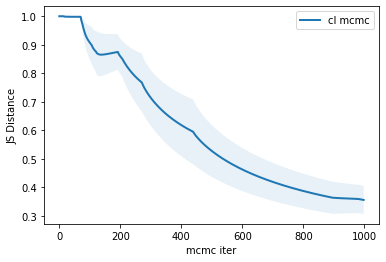

In [ ]:
plot_mean_running_avg(list_running_js,label="cl mcmc")
plt.xlabel("mcmc iter");plt.ylabel("JS Distance");plt.legend()

In [ ]:
### data for plotting running average magnetization (averaged over "num_seperate_mcmc_chains" number of mcmc chains):
first_few=N_hops# 

list_for_df_running_avg_seperate_mcmc = []
for m in range(0, num_seperate_mcmc_chains):
    list_for_df_running_avg_seperate_mcmc.append(running_avg_magnetization_as_list(dict_seperate_chains_accepted_mcmc[m][:first_few+1]))

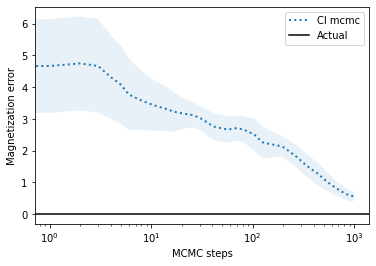

In [ ]:
mean_magnetization = np.mean(list_for_df_running_avg_seperate_mcmc, axis=0) - actual_avg_mag
std_magnetization = np.std(list_for_df_running_avg_seperate_mcmc, axis=0)
plt.fill_between(range(len(mean_magnetization)), mean_magnetization+std_magnetization/2, mean_magnetization-std_magnetization/2, alpha=0.1)

plt.plot(mean_magnetization,":" ,label="Cl mcmc", linewidth=2)

plt.axhline(y=0,linestyle="-", color="k" ,label="Actual")
plt.legend()
# plt.ylim(0, 3)
plt.ylabel("Magnetization error")
plt.xlabel("MCMC steps")
plt.xscale("log")
# plt.yscale("log")
# plt.ylim(1e-2, 3)
plt.show()


In [ ]:
# pandas data_frame for prob distn obtained from different mcmc chains
def fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_mcmc):
    df=pd.DataFrame(dict_seperate_chains_states_mcmc)
    df=df.fillna(0)
    return df

def get_dict_mean_occurences(df_seperate_chains_mcmc_states_occurences):
    mean_occurences=df_seperate_chains_mcmc_states_occurences.mean(axis=1)
    #print("mean occurences:"); print(mean_occurences)
    #print(f"type(mean_occurences): {type(mean_occurences)}")
    dict_mean_occurences=mean_occurences.to_dict()# mean number of occurences; we took mean of data obtained for mcmc chains
    # plt.figure(1); mean_occurences.plot.bar()
    return dict_mean_occurences

def get_empirical_distn(dict_mean_occurences):
    sum_of_counts = sum(dict_mean_occurences.values())
    empirical_probs=list(np.array(list(dict_mean_occurences.values()))/sum_of_counts)
    ### Prob distribution, sorted in descending order of prob values
    dict_empirical_prob_distn=dict(zip(list(dict_mean_occurences.keys()), empirical_probs ))
    return dict_empirical_prob_distn




<Figure size 432x288 with 0 Axes>

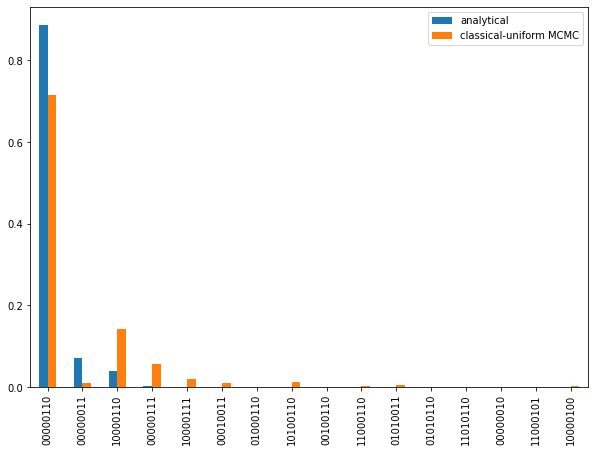

In [ ]:
### for classical mcmc
df_1=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc)
dict_mean_occurences=get_dict_mean_occurences(df_1)
dict_empirical_cl_prob_distn=get_empirical_distn(dict_mean_occurences)

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn],
                        list_labels=["analytical","classical-uniform MCMC"],
                        list_normalise=[False,False] ,plot_first_few=16,  
                        sort_desc=True,figsize=(10,7))

In [ ]:
np.sqrt(js_divergence(boltz_prob_distn,dict_empirical_cl_prob_distn))

0.2762100972848577

### Quantum enhanced MCMC

In [ ]:
# 10 seperate chains of quantum mcmc for the given problem instance
N_hops_q=1000;num_seperate_mcmc_chains_q=4; return_last_n_states_q=N_hops_q
dict_seperate_chains_states_distn_mcmc_q, dict_seperate_chains_sprime_mcmc_q, dict_seperate_chains_accepted_mcmc_q, dict_seperate_chains_energy_diff_s_and_sprime_q,dict_seperate_chains_counts_based_on_hamming_dist_q=run_mcmc_different_chains(n_spins, 
N_hops_q, num_seperate_mcmc_chains_q,
model, temp=temp, return_last_n_states=return_last_n_states_q,
return_both=True, is_quantum_mcmc=True, alpha=alpha )

i: 0
i: 1
i: 2
i: 3


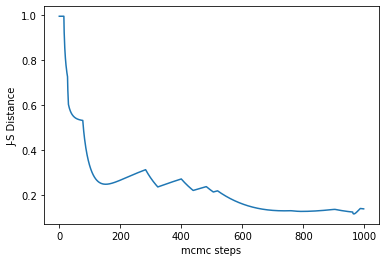

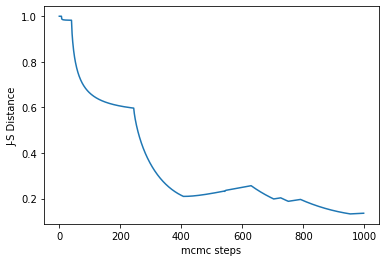

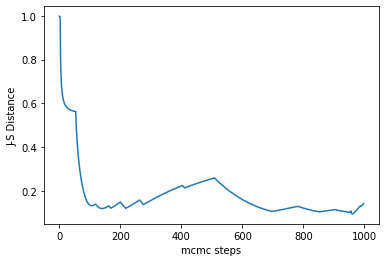

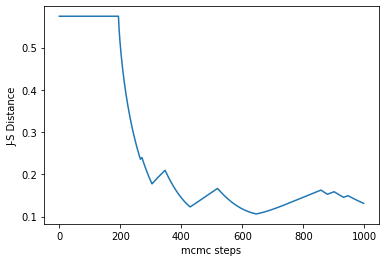

In [ ]:
list_running_js_q=[]
for i in range(0,num_seperate_mcmc_chains):
  print("i:",i)
  chain_accepted_state_q=dict_seperate_chains_accepted_mcmc_q[i]
  running_js_q=running_js_divergence(chain_accepted_state_q,bpd)
  list_running_js_q.append(running_js_q)
  plt.figure()
  plt.plot(np.sqrt(running_js_q))
  plt.xlabel("mcmc steps")
  plt.ylabel("J-S Distance")

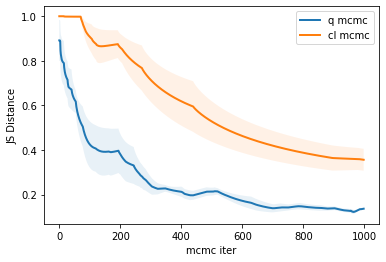

In [ ]:
plot_mean_running_avg(list_running_js_q,label="q mcmc")
plot_mean_running_avg(list_running_js,label="cl mcmc")
plt.xlabel("mcmc iter");plt.ylabel("JS Distance");plt.legend()

In [ ]:
### data for plotting running average magnetization 5 cases seperately:
first_few=N_hops_q# 
list_for_df_running_avg_seperate_mcmc_q = []
for m in range(0, num_seperate_mcmc_chains_q):
    list_for_df_running_avg_seperate_mcmc_q.append(running_avg_magnetization_as_list(dict_seperate_chains_accepted_mcmc_q[m][:first_few+1]))


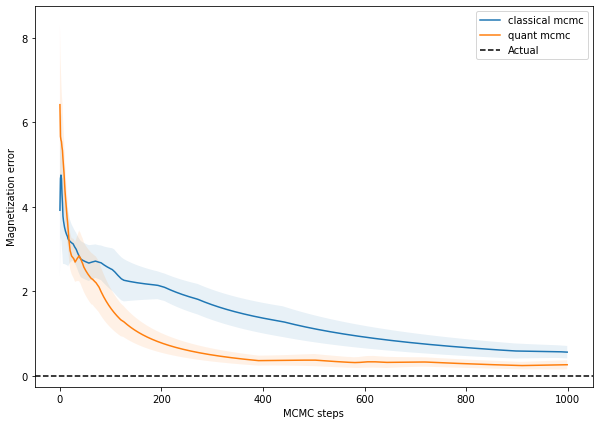

In [ ]:
mean_magnetization_q = np.mean(list_for_df_running_avg_seperate_mcmc_q, axis=0) - actual_avg_mag
std_magnetization_q = np.std(list_for_df_running_avg_seperate_mcmc_q, axis=0)

plt.figure(figsize=(10,7))

plt.fill_between(range(len(mean_magnetization)), mean_magnetization+std_magnetization/2, mean_magnetization-std_magnetization/2, alpha=0.1)
plt.fill_between(range(len(mean_magnetization_q)), mean_magnetization_q+std_magnetization_q/2, mean_magnetization_q-std_magnetization_q/2, alpha=0.1)

# magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
# actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)

plt.plot(mean_magnetization,"-" ,label="classical mcmc")
plt.plot(mean_magnetization_q,"-" ,label="quant mcmc")
plt.axhline(y=0,linestyle="--", color="k" ,label="Actual")
plt.legend()
#plt.ylim(-1, 1)
plt.ylabel("Magnetization error")
plt.xlabel("MCMC steps")
plt.show()

<Figure size 432x288 with 0 Axes>

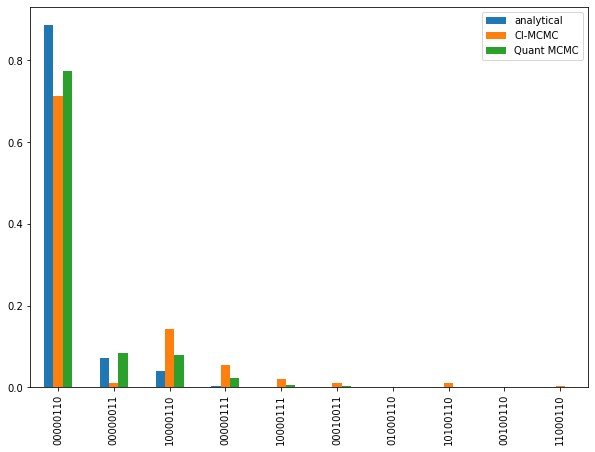

In [ ]:
### for quantum mcmc
df_q=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc_q)
dict_mean_occurences_q=get_dict_mean_occurences(df_q)
dict_empirical_prob_distn_q=get_empirical_distn(dict_mean_occurences_q)

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn,dict_empirical_prob_distn_q],
                        list_labels=["analytical","Cl-MCMC","Quant MCMC"],
                        list_normalise=[False,False,False] ,plot_first_few=10,  
                        sort_desc=True,figsize=(10,7))

In [ ]:
print("JS distance quantum case:");
print(np.sqrt(js_divergence(dict_empirical_prob_distn_q,boltz_prob_distn)))
print("JS distance classical case:")
print(np.sqrt(js_divergence(dict_empirical_cl_prob_distn,boltz_prob_distn)))

JS distance quantum case:
0.18983598800532106
JS distance classical case:
0.2762100972848577


In [ ]:
# def similarity_coefficient(target_prob_distn:dict, model_prob_distn:dict):
#   """ Returns: Bhattacharya coefficient BC(P,Q)= \sum_{i} sqrt(P(i)*Q(i))
#       Args: target_prob_distn: P
#             model_prob_distn: Q, approximates P
#   """
#   list_prob_model=list(target_prob_distn.values())
#   list_prob_data=list(model_prob_distn.values())
#   list_keys_model=list(model_prob_distn.keys())

#   sim_coeff=0
#   for i in range(0,len(list_keys_model)):
#       if(list_prob_data[i]== 0 or list_prob_model==0):
#           to_return+= 0
#       else:
#         sim_coeff+=np.sqrt(list_prob_data[i]*list_prob_model[i])
#   return sim_coeff

# def running_sim_coeff(list_chain_state_accepted:list,actual_boltz_distn:dict):
#   num_nhops=len(list_chain_state_accepted)
#   list_sim_coeff_after_each_step=[]
#   for step_num in range(1,num_nhops):
#     #print("step_num: ",step_num)
#     temp_distn_model=get_distn(list_chain_state_accepted[:step_num])
#     #print("temp_distribution:")
#     #print(temp_distn_model)
#     sim_coeff_temp=similarity_coefficient(actual_boltz_distn,temp_distn_model)
#     list_sim_coeff_after_each_step.append(sim_coeff_temp)
#     print(f"at step={step_num} of MCMC , bhatt.coeff: {sim_coeff_temp}")
#   return list_sim_coeff_after_each_step